In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from PIL import Image
import evaluate
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator

d:\Developer\neural_code_compiler\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [3]:
df = pd.read_csv('dataset.csv ')
df.head()

,img_name,ground_truth
0,1.png,"for(i=0; i<3; i++) {\r\nprintf(""%d"", i);\r\npr..."
1,2.png,"#include <iostream>\r\nint main(int argc, char..."
2,Screenshot 2025-04-11 172314.png,#include<stdio.h>\r\n#include<conio.h>\r\nvoid...
3,Screenshot 2025-04-11 172402.png,#include <stdio.h>\r\nint main()\r\n{\r\nint a...
4,Screenshot 2025-04-11 172445.png,#include<stdio.h>\r\n#include<conio.h>\r\nVoid...


In [4]:
train_df, test_df = train_test_split(df, test_size=0.15)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [5]:
class CodeDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=300):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df['img_name'][idx]
        text = self.df['ground_truth'][idx]

        image_path = os.path.join(self.root_dir, 'dataset_creator', 'images', img_name)
        image = Image.open(image_path).convert('RGB')
        pixel_values = self.processor(image, return_tensors='pt').pixel_values

        # Tokenize and pad the text
        tokenizer_output = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length,
            truncation=True,
            return_tensors='pt'
        )

        labels = tokenizer_output.input_ids.squeeze()
        
        # Replace padding token id with -100 for loss calculation
        labels = torch.where(labels == self.processor.tokenizer.pad_token_id, -100, labels)

        encoding = {
            'pixel_values': pixel_values.squeeze(),
            'labels': labels
        }
        return encoding

In [6]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = CodeDataset(root_dir='',
                            df=train_df,
                            processor=processor)
eval_dataset = CodeDataset(root_dir='',
                            df=test_df,
                            processor=processor)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 61
Number of validation examples: 11


In [8]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([300])


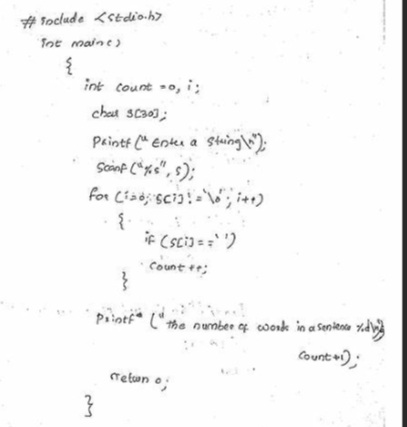

In [9]:
image = Image.open(train_dataset.root_dir + 'dataset_creator/images/' + train_df['img_name'][0]).convert("RGB")
image

In [10]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

#include <stdio.h>
int main()
{
int count=0, i;
char s[30];
printf("Enter a string\n");
scanf("%s",s);
for (i=0;s[i]!='\0';i++)
{
if (s[i]==' ')
count++;
}
printf("the number of words in a sentence is %d\n",count+1);
return 0;
}


## Training

In [11]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

In [12]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 300
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [13]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy="steps",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=True,
    output_dir="./",
    logging_steps=2,
    save_steps=20,
    eval_steps=10,
    # num_train_epochs=15
)

In [14]:
cer_metric = evaluate.load("cer")

In [15]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [16]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

d:\Developer\neural_code_compiler\venv\Lib\site-packages\transformers\models\trocr\processing_trocr.py:152: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
C:\Users\chira\AppData\Local\Temp\ipykernel_17792\1419208463.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
d:\Developer\neural_code_compiler\venv\Lib\site-packages\torch\nn\modules\module.py:1341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss,Cer
10,6.126000,6.156118,1.124678
20,5.334100,5.323682,0.944359
30,5.122600,5.092164,0.926327
40,4.997000,4.891792,1.408552


d:\Developer\neural_code_compiler\venv\Lib\site-packages\transformers\generation\utils.py:1667: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
d:\Developer\neural_code_compiler\venv\Lib\site-packages\transformers\modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 300, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=48, training_loss=5.864099442958832, metrics={'train_runtime': 16095.7785, 'train_samples_per_second': 0.011, 'train_steps_per_second': 0.003, 'total_flos': 1.619358674709381e+17, 'train_loss': 5.864099442958832, 'epoch': 3.0})